In [301]:
from matplotlib.pyplot import show as show_static
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

### SET PLOTTING METRIC

In [302]:
plotting_metric = 'manhattan'
# plotting_metric = 'clr'
# plotting_metric = 'cosine'
# plotting_metric = 'minkowski_0.25'
# plotting_metric = 'minkowski_0.5'
# plotting_metric = 'minkowski_0.75'
# plotting_metric = 'minkowski_1.0'
# plotting_metric = 'minkowski_1.5'
# plotting_metric = 'minkowski_2.0'
# plotting_metric = 'minkowski_3.0'
# plotting_metric = 'minkowski_4.0'
# plotting_metric = 'minkowski_5.0'
# plotting_metric = 'euclidean'

In [303]:
# df_stats = pd.read_csv('./scan_stats_v2.csv')
# df_stats = pd.read_csv('./scan_stats_clr.csv')
# df_stats = pd.read_csv('./scan_stats_metrics2.csv')
df_stats = pd.read_csv('./scan_stats_sklearn_distance.csv')

In [304]:
df_stats['metric'].unique()

array(['manhattan'], dtype=object)

In [305]:
df_stats

,partition_type,dimensionality,metric,graph,nns,clustering,parameter,silhouette_score,modularity,nclusters,mean_cluster_size,median_cluster_size,sd_cluster_size,nenriched_clusters,mean_enriched_cluster_size,median_enriched_cluster_size,sd_enriched_cluster_size,nenriched_cluster_genes,datetime
0,EXP,baseline,manhattan,umap_fuzzy_simplicial_set,2,leiden_cpm,0.1,0.001963,0.627766,2848,7.136938,7.0,1.995834,353,7.821530,7.0,2.463189,2761,2024-02-13 11:07:17.884574
1,EXP,baseline,manhattan,umap_fuzzy_simplicial_set,2,leiden_cpm,0.2,0.013181,0.575148,4034,5.038671,5.0,1.376368,384,5.367188,5.0,1.608268,2061,2024-02-13 11:07:17.884574
2,EXP,baseline,manhattan,umap_fuzzy_simplicial_set,2,leiden_cpm,0.3,0.019086,0.543464,4797,4.237232,4.0,1.146187,420,4.471429,4.0,1.159492,1878,2024-02-13 11:07:17.884574
3,EXP,baseline,manhattan,umap_fuzzy_simplicial_set,2,leiden_cpm,0.4,0.029742,0.498594,5950,3.416134,3.0,0.973053,462,3.770563,4.0,1.033717,1742,2024-02-13 11:07:17.884574
4,EXP,baseline,manhattan,umap_fuzzy_simplicial_set,2,leiden_cpm,0.5,0.037226,0.446886,7282,2.791266,3.0,0.841351,484,3.231405,3.0,0.933848,1564,2024-02-13 11:07:17.884574
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105,EXP,baseline,manhattan,umap_fuzzy_simplicial_set,12,leiden_cpm,0.6,0.061562,0.134599,6247,3.253722,3.0,1.499312,440,4.238636,4.0,1.822800,1865,2024-02-13 11:07:17.884574
106,EXP,baseline,manhattan,umap_fuzzy_simplicial_set,12,leiden_cpm,0.7,0.061192,0.119465,7087,2.868068,3.0,1.332091,467,3.854390,3.0,1.581544,1800,2024-02-13 11:07:17.884574
107,EXP,baseline,manhattan,umap_fuzzy_simplicial_set,12,leiden_cpm,0.8,0.060486,0.107779,7606,2.672364,3.0,1.172339,472,3.561441,3.0,1.377958,1681,2024-02-13 11:07:17.884574
108,EXP,baseline,manhattan,umap_fuzzy_simplicial_set,12,leiden_cpm,0.9,0.059841,0.097687,8094,2.511243,2.0,1.047458,476,3.334034,3.0,1.195131,1587,2024-02-13 11:07:17.884574


In [306]:
df_stats.drop_duplicates(subset=df_stats.columns.difference(['datetime']), inplace=True)

In [307]:
df_stats

,partition_type,dimensionality,metric,graph,nns,clustering,parameter,silhouette_score,modularity,nclusters,mean_cluster_size,median_cluster_size,sd_cluster_size,nenriched_clusters,mean_enriched_cluster_size,median_enriched_cluster_size,sd_enriched_cluster_size,nenriched_cluster_genes,datetime
0,EXP,baseline,manhattan,umap_fuzzy_simplicial_set,2,leiden_cpm,0.1,0.001963,0.627766,2848,7.136938,7.0,1.995834,353,7.821530,7.0,2.463189,2761,2024-02-13 11:07:17.884574
1,EXP,baseline,manhattan,umap_fuzzy_simplicial_set,2,leiden_cpm,0.2,0.013181,0.575148,4034,5.038671,5.0,1.376368,384,5.367188,5.0,1.608268,2061,2024-02-13 11:07:17.884574
2,EXP,baseline,manhattan,umap_fuzzy_simplicial_set,2,leiden_cpm,0.3,0.019086,0.543464,4797,4.237232,4.0,1.146187,420,4.471429,4.0,1.159492,1878,2024-02-13 11:07:17.884574
3,EXP,baseline,manhattan,umap_fuzzy_simplicial_set,2,leiden_cpm,0.4,0.029742,0.498594,5950,3.416134,3.0,0.973053,462,3.770563,4.0,1.033717,1742,2024-02-13 11:07:17.884574
4,EXP,baseline,manhattan,umap_fuzzy_simplicial_set,2,leiden_cpm,0.5,0.037226,0.446886,7282,2.791266,3.0,0.841351,484,3.231405,3.0,0.933848,1564,2024-02-13 11:07:17.884574
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105,EXP,baseline,manhattan,umap_fuzzy_simplicial_set,12,leiden_cpm,0.6,0.061562,0.134599,6247,3.253722,3.0,1.499312,440,4.238636,4.0,1.822800,1865,2024-02-13 11:07:17.884574
106,EXP,baseline,manhattan,umap_fuzzy_simplicial_set,12,leiden_cpm,0.7,0.061192,0.119465,7087,2.868068,3.0,1.332091,467,3.854390,3.0,1.581544,1800,2024-02-13 11:07:17.884574
107,EXP,baseline,manhattan,umap_fuzzy_simplicial_set,12,leiden_cpm,0.8,0.060486,0.107779,7606,2.672364,3.0,1.172339,472,3.561441,3.0,1.377958,1681,2024-02-13 11:07:17.884574
108,EXP,baseline,manhattan,umap_fuzzy_simplicial_set,12,leiden_cpm,0.9,0.059841,0.097687,8094,2.511243,2.0,1.047458,476,3.334034,3.0,1.195131,1587,2024-02-13 11:07:17.884574


In [308]:
def compute_num_clusters_fraction_of_genes_enriched(row):
    return row['nenriched_clusters'] * (row['nenriched_cluster_genes'] / 20326)

In [309]:
df_stats['num_clusters_fraction_of_genes_enriched'] = df_stats.apply(compute_num_clusters_fraction_of_genes_enriched, axis=1)

In [310]:
df_stats

,partition_type,dimensionality,metric,graph,nns,clustering,parameter,silhouette_score,modularity,nclusters,mean_cluster_size,median_cluster_size,sd_cluster_size,nenriched_clusters,mean_enriched_cluster_size,median_enriched_cluster_size,sd_enriched_cluster_size,nenriched_cluster_genes,datetime,num_clusters_fraction_of_genes_enriched
0,EXP,baseline,manhattan,umap_fuzzy_simplicial_set,2,leiden_cpm,0.1,0.001963,0.627766,2848,7.136938,7.0,1.995834,353,7.821530,7.0,2.463189,2761,2024-02-13 11:07:17.884574,47.950064
1,EXP,baseline,manhattan,umap_fuzzy_simplicial_set,2,leiden_cpm,0.2,0.013181,0.575148,4034,5.038671,5.0,1.376368,384,5.367188,5.0,1.608268,2061,2024-02-13 11:07:17.884574,38.936534
2,EXP,baseline,manhattan,umap_fuzzy_simplicial_set,2,leiden_cpm,0.3,0.019086,0.543464,4797,4.237232,4.0,1.146187,420,4.471429,4.0,1.159492,1878,2024-02-13 11:07:17.884574,38.805471
3,EXP,baseline,manhattan,umap_fuzzy_simplicial_set,2,leiden_cpm,0.4,0.029742,0.498594,5950,3.416134,3.0,0.973053,462,3.770563,4.0,1.033717,1742,2024-02-13 11:07:17.884574,39.594805
4,EXP,baseline,manhattan,umap_fuzzy_simplicial_set,2,leiden_cpm,0.5,0.037226,0.446886,7282,2.791266,3.0,0.841351,484,3.231405,3.0,0.933848,1564,2024-02-13 11:07:17.884574,37.241759
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105,EXP,baseline,manhattan,umap_fuzzy_simplicial_set,12,leiden_cpm,0.6,0.061562,0.134599,6247,3.253722,3.0,1.499312,440,4.238636,4.0,1.822800,1865,2024-02-13 11:07:17.884574,40.371937
106,EXP,baseline,manhattan,umap_fuzzy_simplicial_set,12,leiden_cpm,0.7,0.061192,0.119465,7087,2.868068,3.0,1.332091,467,3.854390,3.0,1.581544,1800,2024-02-13 11:07:17.884574,41.355899
107,EXP,baseline,manhattan,umap_fuzzy_simplicial_set,12,leiden_cpm,0.8,0.060486,0.107779,7606,2.672364,3.0,1.172339,472,3.561441,3.0,1.377958,1681,2024-02-13 11:07:17.884574,39.035324
108,EXP,baseline,manhattan,umap_fuzzy_simplicial_set,12,leiden_cpm,0.9,0.059841,0.097687,8094,2.511243,2.0,1.047458,476,3.334034,3.0,1.195131,1587,2024-02-13 11:07:17.884574,37.164814


In [311]:
19 * (19933/20326)

18.632638000590376

In [312]:
df_stats_true = df_stats.loc[df_stats['partition_type'] == 'EXP']
df_stats_neg_ctrl = df_stats.loc[~(df_stats['partition_type'] == 'EXP')]

In [313]:
df_stats_true

,partition_type,dimensionality,metric,graph,nns,clustering,parameter,silhouette_score,modularity,nclusters,mean_cluster_size,median_cluster_size,sd_cluster_size,nenriched_clusters,mean_enriched_cluster_size,median_enriched_cluster_size,sd_enriched_cluster_size,nenriched_cluster_genes,datetime,num_clusters_fraction_of_genes_enriched
0,EXP,baseline,manhattan,umap_fuzzy_simplicial_set,2,leiden_cpm,0.1,0.001963,0.627766,2848,7.136938,7.0,1.995834,353,7.821530,7.0,2.463189,2761,2024-02-13 11:07:17.884574,47.950064
1,EXP,baseline,manhattan,umap_fuzzy_simplicial_set,2,leiden_cpm,0.2,0.013181,0.575148,4034,5.038671,5.0,1.376368,384,5.367188,5.0,1.608268,2061,2024-02-13 11:07:17.884574,38.936534
2,EXP,baseline,manhattan,umap_fuzzy_simplicial_set,2,leiden_cpm,0.3,0.019086,0.543464,4797,4.237232,4.0,1.146187,420,4.471429,4.0,1.159492,1878,2024-02-13 11:07:17.884574,38.805471
3,EXP,baseline,manhattan,umap_fuzzy_simplicial_set,2,leiden_cpm,0.4,0.029742,0.498594,5950,3.416134,3.0,0.973053,462,3.770563,4.0,1.033717,1742,2024-02-13 11:07:17.884574,39.594805
4,EXP,baseline,manhattan,umap_fuzzy_simplicial_set,2,leiden_cpm,0.5,0.037226,0.446886,7282,2.791266,3.0,0.841351,484,3.231405,3.0,0.933848,1564,2024-02-13 11:07:17.884574,37.241759
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105,EXP,baseline,manhattan,umap_fuzzy_simplicial_set,12,leiden_cpm,0.6,0.061562,0.134599,6247,3.253722,3.0,1.499312,440,4.238636,4.0,1.822800,1865,2024-02-13 11:07:17.884574,40.371937
106,EXP,baseline,manhattan,umap_fuzzy_simplicial_set,12,leiden_cpm,0.7,0.061192,0.119465,7087,2.868068,3.0,1.332091,467,3.854390,3.0,1.581544,1800,2024-02-13 11:07:17.884574,41.355899
107,EXP,baseline,manhattan,umap_fuzzy_simplicial_set,12,leiden_cpm,0.8,0.060486,0.107779,7606,2.672364,3.0,1.172339,472,3.561441,3.0,1.377958,1681,2024-02-13 11:07:17.884574,39.035324
108,EXP,baseline,manhattan,umap_fuzzy_simplicial_set,12,leiden_cpm,0.9,0.059841,0.097687,8094,2.511243,2.0,1.047458,476,3.334034,3.0,1.195131,1587,2024-02-13 11:07:17.884574,37.164814


In [314]:
df_stats_neg_ctrl

,partition_type,dimensionality,metric,graph,nns,clustering,parameter,silhouette_score,modularity,nclusters,mean_cluster_size,median_cluster_size,sd_cluster_size,nenriched_clusters,mean_enriched_cluster_size,median_enriched_cluster_size,sd_enriched_cluster_size,nenriched_cluster_genes,datetime,num_clusters_fraction_of_genes_enriched


In [315]:
df_true_cluster = df_stats_true.loc[
    (df_stats_true['nns'] == 10) & 
    (df_stats_true['parameter'] == 0.0105) & 

    (df_stats_true['dimensionality'] == 'baseline') &
    (df_stats_true['graph'] == 'umap_fuzzy_simplicial_set') &
    (df_stats_true['clustering'] == 'leiden_cpm') &
    (df_stats_true['metric'] == plotting_metric) 
]

In [316]:
df_neg_ctrls = df_stats_neg_ctrl.loc[
    (df_stats_neg_ctrl['nns'] == 10) & 
    (df_stats_neg_ctrl['parameter'] == 0.0105) & 

    (df_stats_neg_ctrl['dimensionality'] == 'baseline') &
    (df_stats_neg_ctrl['graph'] == 'umap_fuzzy_simplicial_set') &
    (df_stats_neg_ctrl['clustering'] == 'leiden_cpm') &
    (df_stats_neg_ctrl['metric'] == plotting_metric) 
]

In [317]:
df_true_cluster

,partition_type,dimensionality,metric,graph,nns,clustering,parameter,silhouette_score,modularity,nclusters,mean_cluster_size,median_cluster_size,sd_cluster_size,nenriched_clusters,mean_enriched_cluster_size,median_enriched_cluster_size,sd_enriched_cluster_size,nenriched_cluster_genes,datetime,num_clusters_fraction_of_genes_enriched


In [318]:
df_neg_ctrls

,partition_type,dimensionality,metric,graph,nns,clustering,parameter,silhouette_score,modularity,nclusters,mean_cluster_size,median_cluster_size,sd_cluster_size,nenriched_clusters,mean_enriched_cluster_size,median_enriched_cluster_size,sd_enriched_cluster_size,nenriched_cluster_genes,datetime,num_clusters_fraction_of_genes_enriched


In [319]:
hist_clustering_metric = 'silhouette_score'
# hist_clustering_metric = 'modularity'

hist_data = df_neg_ctrls[hist_clustering_metric].values
hist_data

array([], dtype=float64)

In [320]:
# hist_line_at_x = df_true_cluster[hist_clustering_metric].values[0]
# hist_line_at_x

In [321]:
# # Create the histogram
# plt.hist(hist_data, bins=30, edgecolor='black')

# # Add a vertical line at the specified x value
# plt.axvline(x=hist_line_at_x, color='red', linestyle='dashed', linewidth=2, label='experimental at x={}'.format(round(hist_line_at_x, 2)))

# # Add labels and title
# plt.xlabel(hist_clustering_metric)
# plt.ylabel('frequency')
# plt.title(f'{len(hist_data)} neg. controls vs. experimental {hist_clustering_metric} distribution')

# plt.legend()

# # Show the plot
# plt.show()

In [322]:
df_stats_true['silhouette_score'].mean()

0.04887917752321985

In [323]:
df_stats_true['silhouette_score'].median()

0.05244693930323835

In [324]:
df_stats_true['silhouette_score'].max()

0.0615621399967751

In [325]:
df_stats_true['modularity'].mean()

0.26039231772026006

In [326]:
df_stats_neg_ctrl['silhouette_score'].mean()

nan

In [327]:
df_stats_neg_ctrl['silhouette_score'].median()

nan

In [328]:
df_stats_neg_ctrl['silhouette_score'].max()

nan

In [329]:
df_stats_neg_ctrl['modularity'].mean()

nan

In [330]:
df_stats_neg_ctrl['modularity'].median()

nan

In [331]:
df_stats_true['nns'].unique()

array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])

In [332]:
df_stats_true['parameter'].unique()

array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

In [333]:
df_stats_true['parameter'].min()

0.1

In [334]:
df_stats_true.loc[df_stats_true['modularity'] > 0.8]

,partition_type,dimensionality,metric,graph,nns,clustering,parameter,silhouette_score,modularity,nclusters,mean_cluster_size,median_cluster_size,sd_cluster_size,nenriched_clusters,mean_enriched_cluster_size,median_enriched_cluster_size,sd_enriched_cluster_size,nenriched_cluster_genes,datetime,num_clusters_fraction_of_genes_enriched


In [335]:
df_stats_true.loc[(df_stats_true['silhouette_score'] > 0.04) & (df_stats_true['nclusters'] > 100)]

,partition_type,dimensionality,metric,graph,nns,clustering,parameter,silhouette_score,modularity,nclusters,mean_cluster_size,median_cluster_size,sd_cluster_size,nenriched_clusters,mean_enriched_cluster_size,median_enriched_cluster_size,sd_enriched_cluster_size,nenriched_cluster_genes,datetime,num_clusters_fraction_of_genes_enriched
13,EXP,baseline,manhattan,umap_fuzzy_simplicial_set,3,leiden_cpm,0.4,0.041400,0.405514,5549,3.663002,3.0,1.284240,446,4.224215,4.0,1.363833,1884,2024-02-13 11:07:17.884574,41.339368
14,EXP,baseline,manhattan,umap_fuzzy_simplicial_set,3,leiden_cpm,0.5,0.043722,0.375240,6516,3.119398,3.0,1.140465,450,3.724444,4.0,1.199844,1676,2024-02-13 11:07:17.884574,37.105185
15,EXP,baseline,manhattan,umap_fuzzy_simplicial_set,3,leiden_cpm,0.6,0.046064,0.354280,7032,2.890501,3.0,1.007204,471,3.496815,3.0,1.107536,1647,2024-02-13 11:07:17.884574,38.164764
16,EXP,baseline,manhattan,umap_fuzzy_simplicial_set,3,leiden_cpm,0.7,0.045276,0.335739,7620,2.667454,3.0,0.926521,471,3.220807,3.0,0.940971,1517,2024-02-13 11:07:17.884574,35.152366
17,EXP,baseline,manhattan,umap_fuzzy_simplicial_set,3,leiden_cpm,0.8,0.045636,0.319237,8088,2.513106,2.0,0.890146,473,3.131078,3.0,0.889061,1481,2024-02-13 11:07:17.884574,34.463889
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105,EXP,baseline,manhattan,umap_fuzzy_simplicial_set,12,leiden_cpm,0.6,0.061562,0.134599,6247,3.253722,3.0,1.499312,440,4.238636,4.0,1.822800,1865,2024-02-13 11:07:17.884574,40.371937
106,EXP,baseline,manhattan,umap_fuzzy_simplicial_set,12,leiden_cpm,0.7,0.061192,0.119465,7087,2.868068,3.0,1.332091,467,3.854390,3.0,1.581544,1800,2024-02-13 11:07:17.884574,41.355899
107,EXP,baseline,manhattan,umap_fuzzy_simplicial_set,12,leiden_cpm,0.8,0.060486,0.107779,7606,2.672364,3.0,1.172339,472,3.561441,3.0,1.377958,1681,2024-02-13 11:07:17.884574,39.035324
108,EXP,baseline,manhattan,umap_fuzzy_simplicial_set,12,leiden_cpm,0.9,0.059841,0.097687,8094,2.511243,2.0,1.047458,476,3.334034,3.0,1.195131,1587,2024-02-13 11:07:17.884574,37.164814


In [336]:
df_stats_true.loc[df_stats_true['nclusters'] < 10]

,partition_type,dimensionality,metric,graph,nns,clustering,parameter,silhouette_score,modularity,nclusters,mean_cluster_size,median_cluster_size,sd_cluster_size,nenriched_clusters,mean_enriched_cluster_size,median_enriched_cluster_size,sd_enriched_cluster_size,nenriched_cluster_genes,datetime,num_clusters_fraction_of_genes_enriched


In [337]:
df_stats_true.loc[(df_stats_true['metric'] != 'manhattan') & (df_stats_true['metric'] != 'euclidean')]

,partition_type,dimensionality,metric,graph,nns,clustering,parameter,silhouette_score,modularity,nclusters,mean_cluster_size,median_cluster_size,sd_cluster_size,nenriched_clusters,mean_enriched_cluster_size,median_enriched_cluster_size,sd_enriched_cluster_size,nenriched_cluster_genes,datetime,num_clusters_fraction_of_genes_enriched


In [338]:
df_stats_true.loc[(df_stats_true['metric'] != 'cosine') & (df_stats_true['metric'] != 'euclidean') & (df_stats_true['nns'] == 12) & (df_stats_true['parameter'] == 0.095)]

,partition_type,dimensionality,metric,graph,nns,clustering,parameter,silhouette_score,modularity,nclusters,mean_cluster_size,median_cluster_size,sd_cluster_size,nenriched_clusters,mean_enriched_cluster_size,median_enriched_cluster_size,sd_enriched_cluster_size,nenriched_cluster_genes,datetime,num_clusters_fraction_of_genes_enriched


In [339]:
df_stats_true.loc[(df_stats_true['metric'] != 'manhattan') & (df_stats_true['metric'] != 'euclidean')]

,partition_type,dimensionality,metric,graph,nns,clustering,parameter,silhouette_score,modularity,nclusters,mean_cluster_size,median_cluster_size,sd_cluster_size,nenriched_clusters,mean_enriched_cluster_size,median_enriched_cluster_size,sd_enriched_cluster_size,nenriched_cluster_genes,datetime,num_clusters_fraction_of_genes_enriched


In [340]:
for p in (df_stats_true['parameter'].unique()):
    pdf = df_stats_true.loc[df_stats_true['parameter'] == p]
    max_pdf = pdf.loc[pdf['silhouette_score'] == pdf['silhouette_score'].max()]
    print(max_pdf[['nns', 'silhouette_score', 'nclusters']])

     nns  silhouette_score  nclusters
100   12          0.042639       1664
    nns  silhouette_score  nclusters
91   11          0.050231       2890
     nns  silhouette_score  nclusters
102   12          0.054911       3853
     nns  silhouette_score  nclusters
103   12          0.059698       4753
     nns  silhouette_score  nclusters
104   12          0.061001       5622
     nns  silhouette_score  nclusters
105   12          0.061562       6247
    nns  silhouette_score  nclusters
96   11          0.061302       7101
    nns  silhouette_score  nclusters
97   11          0.060846       7589
     nns  silhouette_score  nclusters
108   12          0.059841       8094
     nns  silhouette_score  nclusters
109   12          0.055963       9169


In [341]:
# Create an empty DataFrame to store the results
best_nn_df = pd.DataFrame(columns=['parameter', 'nns', 'silhouette_score', 'nclusters'])

# Iterate over unique parameters
for p in df_stats_true['parameter'].unique():
    pdf = df_stats_true.loc[df_stats_true['parameter'] == p]
    
    # Find the row with the maximum silhouette_score
    max_pdf = pdf.loc[pdf['silhouette_score'].idxmax()]
    
    # Append the relevant information to the result DataFrame
    best_nn_df = best_nn_df.append({'parameter': p, 'nns': max_pdf['nns'],
                                  'silhouette_score': max_pdf['silhouette_score'],
                                  'nclusters': max_pdf['nclusters'],
                                  'nenriched_clusters': max_pdf['nenriched_clusters'],
                                  'nenriched_cluster_genes': max_pdf['nenriched_cluster_genes']
                                  }, ignore_index=True)
    

best_nn_df[best_nn_df['nclusters'] > 50]

,parameter,nns,silhouette_score,nclusters,nenriched_cluster_genes,nenriched_clusters
0,0.1,12.0,0.042639,1664.0,4288.0,281.0
1,0.2,11.0,0.050231,2890.0,3270.0,380.0
2,0.3,12.0,0.054911,3853.0,2716.0,402.0
3,0.4,12.0,0.059698,4753.0,2203.0,397.0
4,0.5,12.0,0.061001,5622.0,2134.0,452.0
5,0.6,12.0,0.061562,6247.0,1865.0,440.0
6,0.7,11.0,0.061302,7101.0,1865.0,480.0
7,0.8,11.0,0.060846,7589.0,1740.0,485.0
8,0.9,12.0,0.059841,8094.0,1587.0,476.0
9,1.0,12.0,0.055963,9169.0,1469.0,463.0


# CONSTRAINED NN PLOTTING PARAMETERS

In [342]:
# PLOTTING PARAMETERS
df = df_stats_true.loc[
    (df_stats_true['nns'] == 10) & 
    # (df_stats_true['parameter'] == 0.0005) & 

    (df_stats_true['dimensionality'] == 'baseline') &
    (df_stats_true['graph'] == 'umap_fuzzy_simplicial_set') &
    (df_stats_true['clustering'] == 'leiden_cpm') &
    (df_stats_true['metric'] == plotting_metric) &
    (df_stats_true['nclusters'] > 50)
]

df

,partition_type,dimensionality,metric,graph,nns,clustering,parameter,silhouette_score,modularity,nclusters,mean_cluster_size,median_cluster_size,sd_cluster_size,nenriched_clusters,mean_enriched_cluster_size,median_enriched_cluster_size,sd_enriched_cluster_size,nenriched_cluster_genes,datetime,num_clusters_fraction_of_genes_enriched
80,EXP,baseline,manhattan,umap_fuzzy_simplicial_set,10,leiden_cpm,0.1,0.039993,0.332357,1731,11.742345,10.0,6.385963,297,14.441077,13.0,7.367053,4289,2024-02-13 11:07:17.884574,62.670127
81,EXP,baseline,manhattan,umap_fuzzy_simplicial_set,10,leiden_cpm,0.2,0.048439,0.264481,2928,6.941940,6.0,3.515973,367,8.457766,8.0,4.028879,3104,2024-02-13 11:07:17.884574,56.044869
82,EXP,baseline,manhattan,umap_fuzzy_simplicial_set,10,leiden_cpm,0.3,0.054368,0.224555,3935,5.165438,5.0,2.561136,413,6.428571,6.0,2.999250,2655,2024-02-13 11:07:17.884574,53.946423
83,EXP,baseline,manhattan,umap_fuzzy_simplicial_set,10,leiden_cpm,0.4,0.056627,0.196348,4790,4.243424,4.0,2.037035,417,5.419664,5.0,2.482340,2260,2024-02-13 11:07:17.884574,46.365246
84,EXP,baseline,manhattan,umap_fuzzy_simplicial_set,10,leiden_cpm,0.5,0.060108,0.173062,5664,3.588630,3.0,1.703763,445,4.651685,4.0,2.108842,2070,2024-02-13 11:07:17.884574,45.318804
85,EXP,baseline,manhattan,umap_fuzzy_simplicial_set,10,leiden_cpm,0.6,0.060546,0.154632,6319,3.216648,3.0,1.462103,437,4.215103,4.0,1.776905,1842,2024-02-13 11:07:17.884574,39.602184
86,EXP,baseline,manhattan,umap_fuzzy_simplicial_set,10,leiden_cpm,0.7,0.059882,0.138195,7155,2.840811,3.0,1.299233,465,3.797849,3.0,1.528931,1766,2024-02-13 11:07:17.884574,40.400964
87,EXP,baseline,manhattan,umap_fuzzy_simplicial_set,10,leiden_cpm,0.8,0.060160,0.126039,7607,2.672013,3.0,1.148651,476,3.579832,3.0,1.344118,1704,2024-02-13 11:07:17.884574,39.904753
88,EXP,baseline,manhattan,umap_fuzzy_simplicial_set,10,leiden_cpm,0.9,0.058241,0.114729,8108,2.506907,2.0,1.028492,496,3.328629,3.0,1.185798,1651,2024-02-13 11:07:17.884574,40.288104
89,EXP,baseline,manhattan,umap_fuzzy_simplicial_set,10,leiden_cpm,1.0,0.054734,0.102199,9206,2.207908,2.0,0.982249,467,3.147752,3.0,1.158531,1470,2024-02-13 11:07:17.884574,33.773984


In [343]:
df_stats_true.loc[
    (df_stats_true['dimensionality'] == 'baseline')
    & (df_stats_true['graph'] == 'umap_fuzzy_simplicial_set')
    & (df_stats_true['clustering'] == 'leiden_cpm') 
    & (df_stats_true['metric'] == plotting_metric) 
    & (df_stats_true['nenriched_cluster_genes'] > 5000) 
    & (df_stats_true['nenriched_cluster_genes'] < 6000) 
    & (df_stats_true['nclusters'] > 1000)
    & (df_stats_true['nclusters'] < 1300)
]

,partition_type,dimensionality,metric,graph,nns,clustering,parameter,silhouette_score,modularity,nclusters,mean_cluster_size,median_cluster_size,sd_cluster_size,nenriched_clusters,mean_enriched_cluster_size,median_enriched_cluster_size,sd_enriched_cluster_size,nenriched_cluster_genes,datetime,num_clusters_fraction_of_genes_enriched


In [344]:
df_stats_true.loc[
    (df_stats_true['dimensionality'] == 'baseline')
    & (df_stats_true['graph'] == 'umap_fuzzy_simplicial_set')
    & (df_stats_true['clustering'] == 'leiden_cpm') 
    & (df_stats_true['metric'] == plotting_metric) 
    & (df_stats_true['nclusters'] > 1000)
    & (df_stats_true['nclusters'] < 1300)
]

,partition_type,dimensionality,metric,graph,nns,clustering,parameter,silhouette_score,modularity,nclusters,mean_cluster_size,median_cluster_size,sd_cluster_size,nenriched_clusters,mean_enriched_cluster_size,median_enriched_cluster_size,sd_enriched_cluster_size,nenriched_cluster_genes,datetime,num_clusters_fraction_of_genes_enriched


In [345]:
df_stats_true.loc[
    (df_stats_true['num_clusters_fraction_of_genes_enriched'] == df_stats_true['num_clusters_fraction_of_genes_enriched'].max())
]

,partition_type,dimensionality,metric,graph,nns,clustering,parameter,silhouette_score,modularity,nclusters,mean_cluster_size,median_cluster_size,sd_cluster_size,nenriched_clusters,mean_enriched_cluster_size,median_enriched_cluster_size,sd_enriched_cluster_size,nenriched_cluster_genes,datetime,num_clusters_fraction_of_genes_enriched
80,EXP,baseline,manhattan,umap_fuzzy_simplicial_set,10,leiden_cpm,0.1,0.039993,0.332357,1731,11.742345,10.0,6.385963,297,14.441077,13.0,7.367053,4289,2024-02-13 11:07:17.884574,62.670127


In [346]:
df_stats_true.loc[
    (df_stats_true['nenriched_cluster_genes'] == df_stats_true['nenriched_cluster_genes'].max())
]

,partition_type,dimensionality,metric,graph,nns,clustering,parameter,silhouette_score,modularity,nclusters,mean_cluster_size,median_cluster_size,sd_cluster_size,nenriched_clusters,mean_enriched_cluster_size,median_enriched_cluster_size,sd_enriched_cluster_size,nenriched_cluster_genes,datetime,num_clusters_fraction_of_genes_enriched
90,EXP,baseline,manhattan,umap_fuzzy_simplicial_set,11,leiden_cpm,0.1,0.041446,0.321633,1692,12.013002,11.0,6.65352,290,14.955172,14.0,7.609979,4337,2024-02-13 11:07:17.884574,61.87789


# Upper limit of nenriched_cluster_genes: 6625 genes (32.59%)

In [347]:
df.loc[df['nenriched_clusters']==df['nenriched_clusters'].max()]

,partition_type,dimensionality,metric,graph,nns,clustering,parameter,silhouette_score,modularity,nclusters,mean_cluster_size,median_cluster_size,sd_cluster_size,nenriched_clusters,mean_enriched_cluster_size,median_enriched_cluster_size,sd_enriched_cluster_size,nenriched_cluster_genes,datetime,num_clusters_fraction_of_genes_enriched
88,EXP,baseline,manhattan,umap_fuzzy_simplicial_set,10,leiden_cpm,0.9,0.058241,0.114729,8108,2.506907,2.0,1.028492,496,3.328629,3.0,1.185798,1651,2024-02-13 11:07:17.884574,40.288104


In [348]:
# 10NN local maxs (sklearn NN)
df.loc[
    (df['parameter']==0.1)
    ]

,partition_type,dimensionality,metric,graph,nns,clustering,parameter,silhouette_score,modularity,nclusters,mean_cluster_size,median_cluster_size,sd_cluster_size,nenriched_clusters,mean_enriched_cluster_size,median_enriched_cluster_size,sd_enriched_cluster_size,nenriched_cluster_genes,datetime,num_clusters_fraction_of_genes_enriched
80,EXP,baseline,manhattan,umap_fuzzy_simplicial_set,10,leiden_cpm,0.1,0.039993,0.332357,1731,11.742345,10.0,6.385963,297,14.441077,13.0,7.367053,4289,2024-02-13 11:07:17.884574,62.670127


In [349]:
# 2NN local maxs
df.loc[
    (df['parameter']==0.280)
    ]

,partition_type,dimensionality,metric,graph,nns,clustering,parameter,silhouette_score,modularity,nclusters,mean_cluster_size,median_cluster_size,sd_cluster_size,nenriched_clusters,mean_enriched_cluster_size,median_enriched_cluster_size,sd_enriched_cluster_size,nenriched_cluster_genes,datetime,num_clusters_fraction_of_genes_enriched


In [350]:
# 3NN local maxs
df.loc[
    (df['parameter']==0.900)
    | (df['parameter']==0.605)
    | (df['parameter']==0.536)
    | (df['parameter']==0.485)
    | (df['parameter']==0.340)
    | (df['parameter']==0.075)
    ]

,partition_type,dimensionality,metric,graph,nns,clustering,parameter,silhouette_score,modularity,nclusters,mean_cluster_size,median_cluster_size,sd_cluster_size,nenriched_clusters,mean_enriched_cluster_size,median_enriched_cluster_size,sd_enriched_cluster_size,nenriched_cluster_genes,datetime,num_clusters_fraction_of_genes_enriched
88,EXP,baseline,manhattan,umap_fuzzy_simplicial_set,10,leiden_cpm,0.9,0.058241,0.114729,8108,2.506907,2.0,1.028492,496,3.328629,3.0,1.185798,1651,2024-02-13 11:07:17.884574,40.288104


In [351]:
# 5NN local maxs
df.loc[
    (df['parameter']==0.935)
    | (df['parameter']==0.795)
    | (df['parameter']==0.640)
    | (df['parameter']==0.465)
    | (df['parameter']==0.350)
    | (df['parameter']==0.295)
    | (df['parameter']==0.190)
    | (df['parameter']==0.125)
    | (df['parameter']==0.0499999999999999)
    | (df['parameter']==0.0349999999999999)
    ]

,partition_type,dimensionality,metric,graph,nns,clustering,parameter,silhouette_score,modularity,nclusters,mean_cluster_size,median_cluster_size,sd_cluster_size,nenriched_clusters,mean_enriched_cluster_size,median_enriched_cluster_size,sd_enriched_cluster_size,nenriched_cluster_genes,datetime,num_clusters_fraction_of_genes_enriched


In [352]:
# 6NN local maxs
df.loc[
    (df['parameter']==0.800)
    | (df['parameter']==0.665)
    | (df['parameter']==0.435)
    ]

,partition_type,dimensionality,metric,graph,nns,clustering,parameter,silhouette_score,modularity,nclusters,mean_cluster_size,median_cluster_size,sd_cluster_size,nenriched_clusters,mean_enriched_cluster_size,median_enriched_cluster_size,sd_enriched_cluster_size,nenriched_cluster_genes,datetime,num_clusters_fraction_of_genes_enriched
87,EXP,baseline,manhattan,umap_fuzzy_simplicial_set,10,leiden_cpm,0.8,0.06016,0.126039,7607,2.672013,3.0,1.148651,476,3.579832,3.0,1.344118,1704,2024-02-13 11:07:17.884574,39.904753


In [353]:
y = 'nenriched_clusters'
# y = 'num_clusters_fraction_of_genes_enriched'

# x = 'silhouette_score'
x = 'modularity'

labels = 'parameter'
# labels = 'nns'

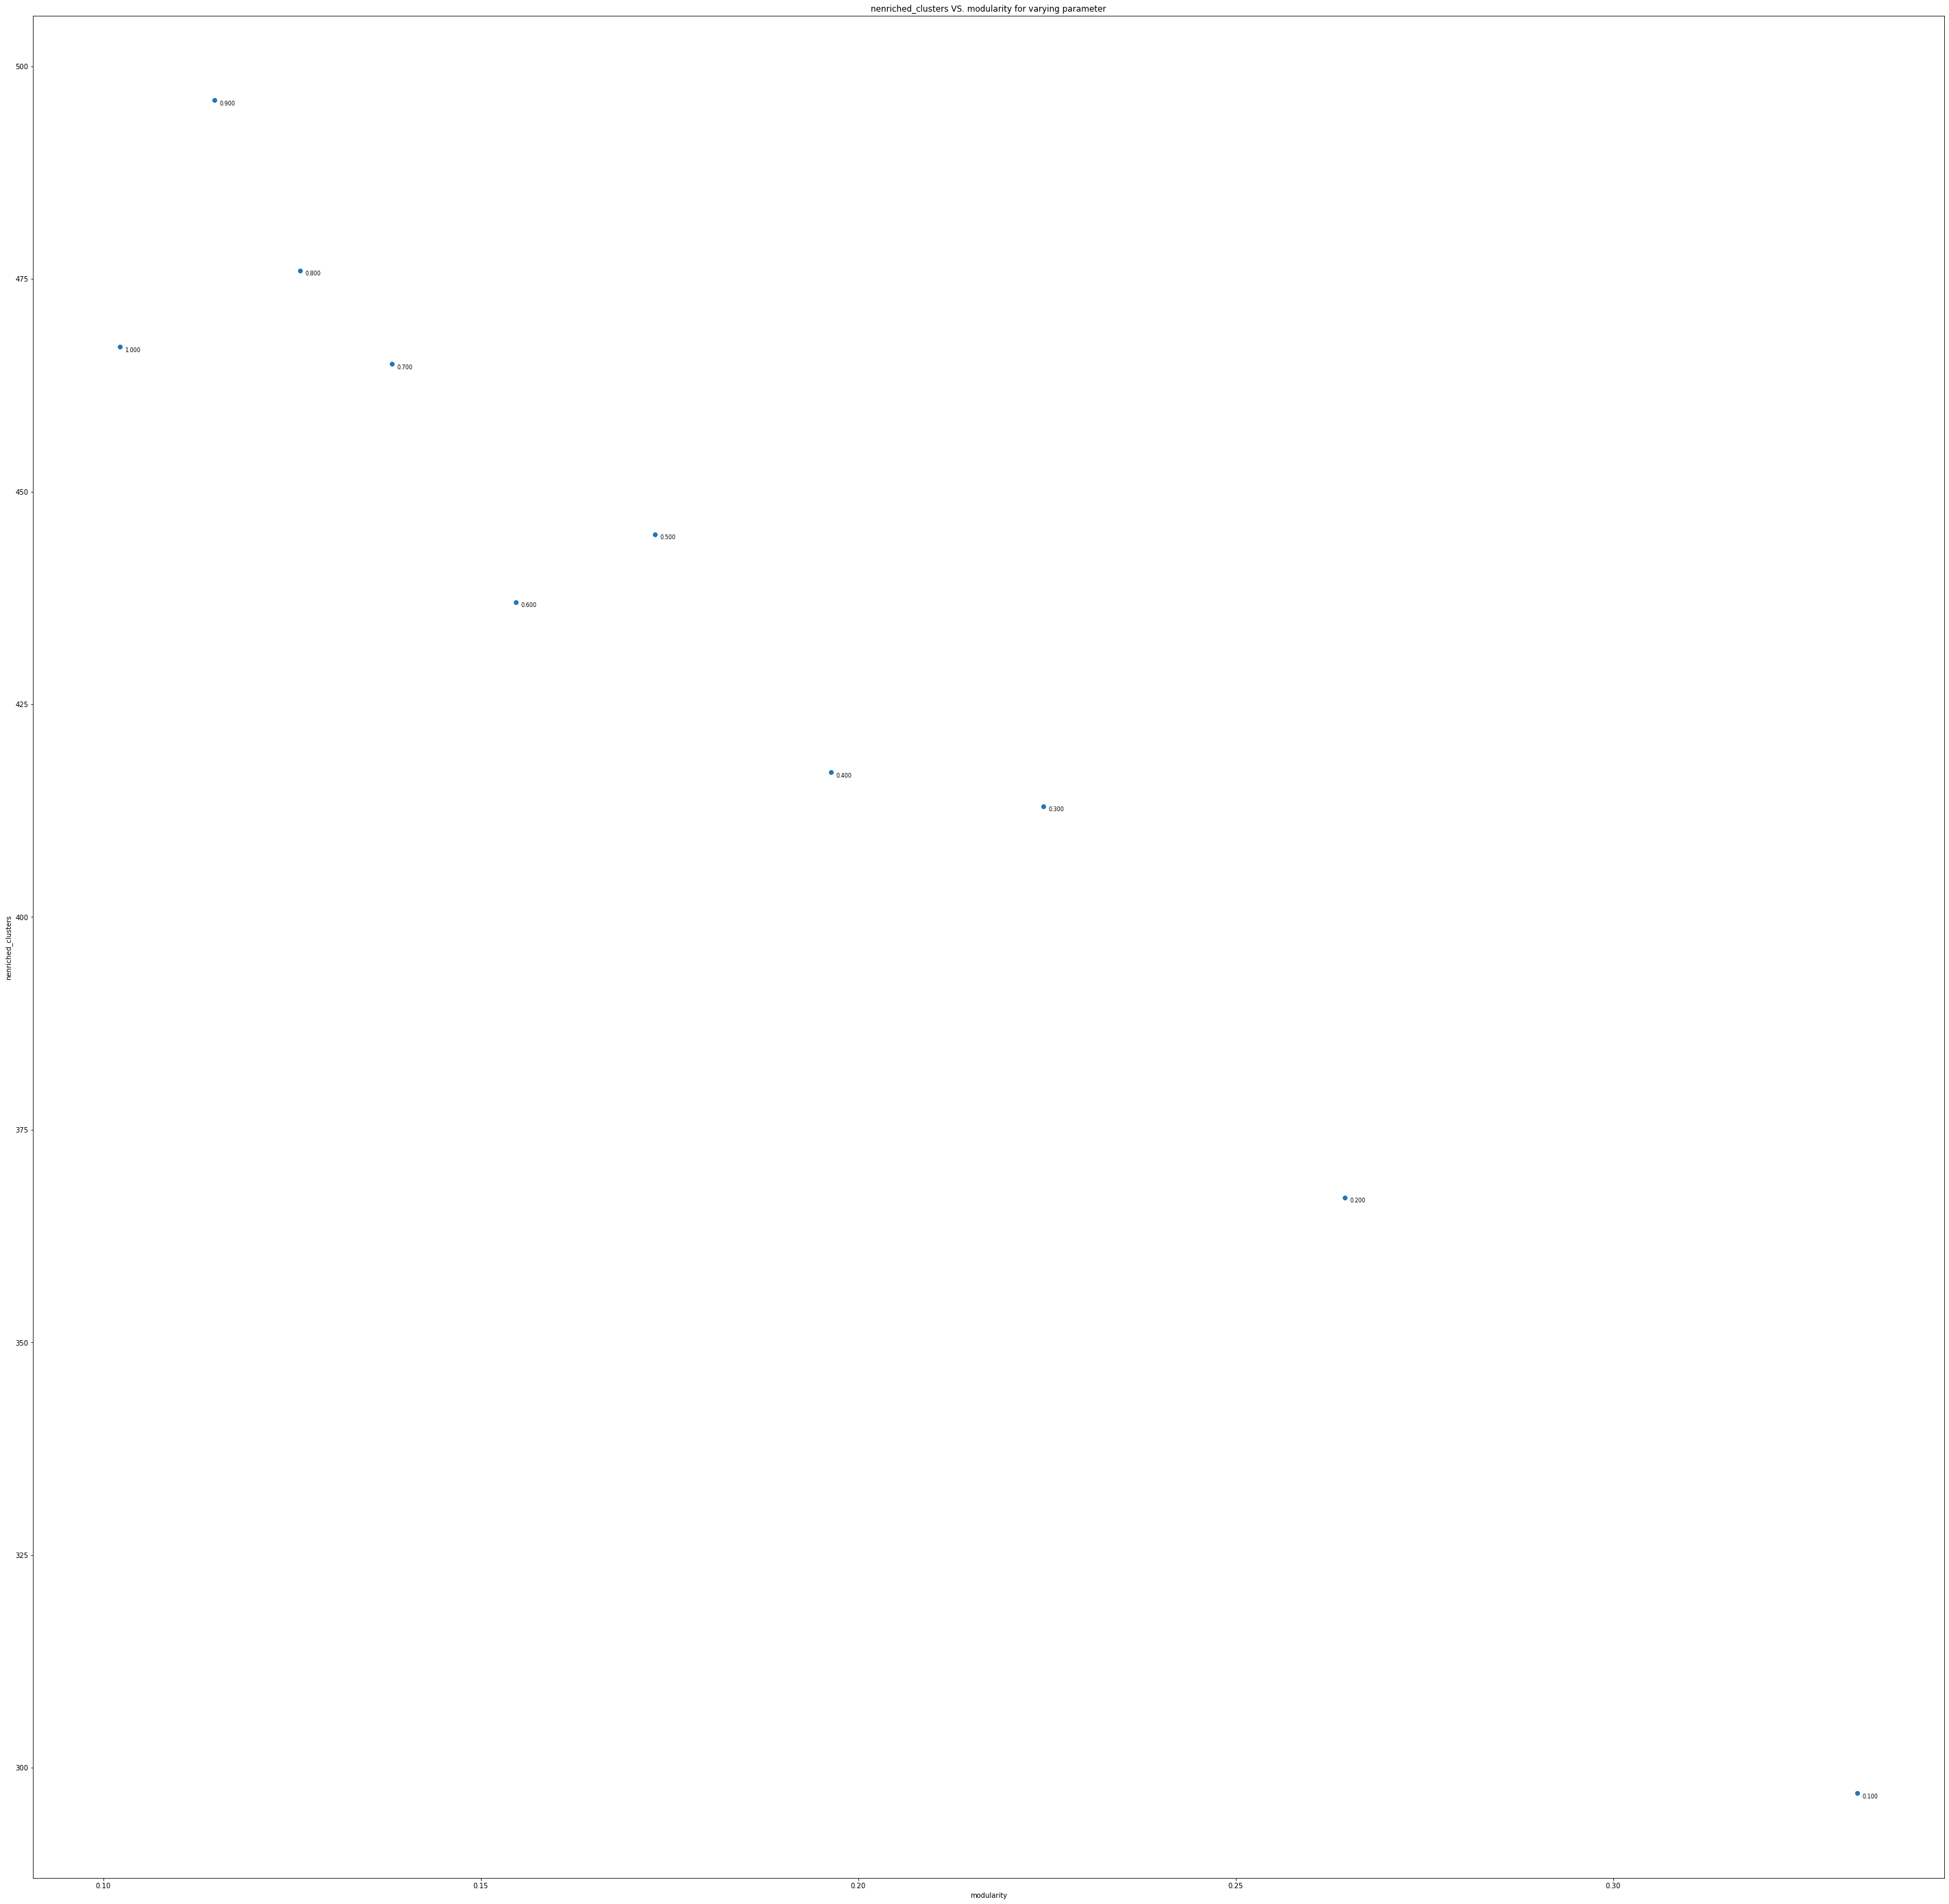

In [354]:
x_in = 50
y_in = 50
# x_in = 15
# y_in = 10
plt.figure(figsize=(x_in, y_in))

# Create scatter plot
plt.scatter(df[x].values, df[y].values)

label_adj_x = (0
            + (df[x].max() - df[x].min()) * 0.0075
            # + x_in/6.4
                )
label_adj_y = (0 
            # + (y_in/4.8)
               )

# Label each point with the number of nearest neighbors below the point
for i, txt in enumerate(df[labels].values):
    plt.text(df[x].values[i] + label_adj_x, df[y].values[i] + label_adj_y, 
            str("{:.3f}".format(
                txt
                ))
                ,
            fontsize=8, ha='center', va='top', color='black')

# Set axis labels and title
plt.xlabel(x)
plt.ylabel(y)
plt.title(f'{y} VS. {x} for varying {labels}')

# Display the plot
plt.show()

In [355]:
df_stats_true['parameter'].unique()

array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

# NN CURVES FOR VARYING RP PLOTTING PARAMETERS

In [356]:
plot_ps = sorted(df_stats_true['parameter'].unique())

# if plotting_metric == 'manhattan':
#     plot_ps = []

#     for p_idx in np.arange(19, len(df_stats_true['parameter'].unique()), 20):
#         plot_ps.append(sorted(df_stats_true['parameter'].unique())[p_idx])

In [357]:
import distinctipy

num_colors = len(df_stats_true['parameter'].unique())

colors = distinctipy.get_colors(num_colors)

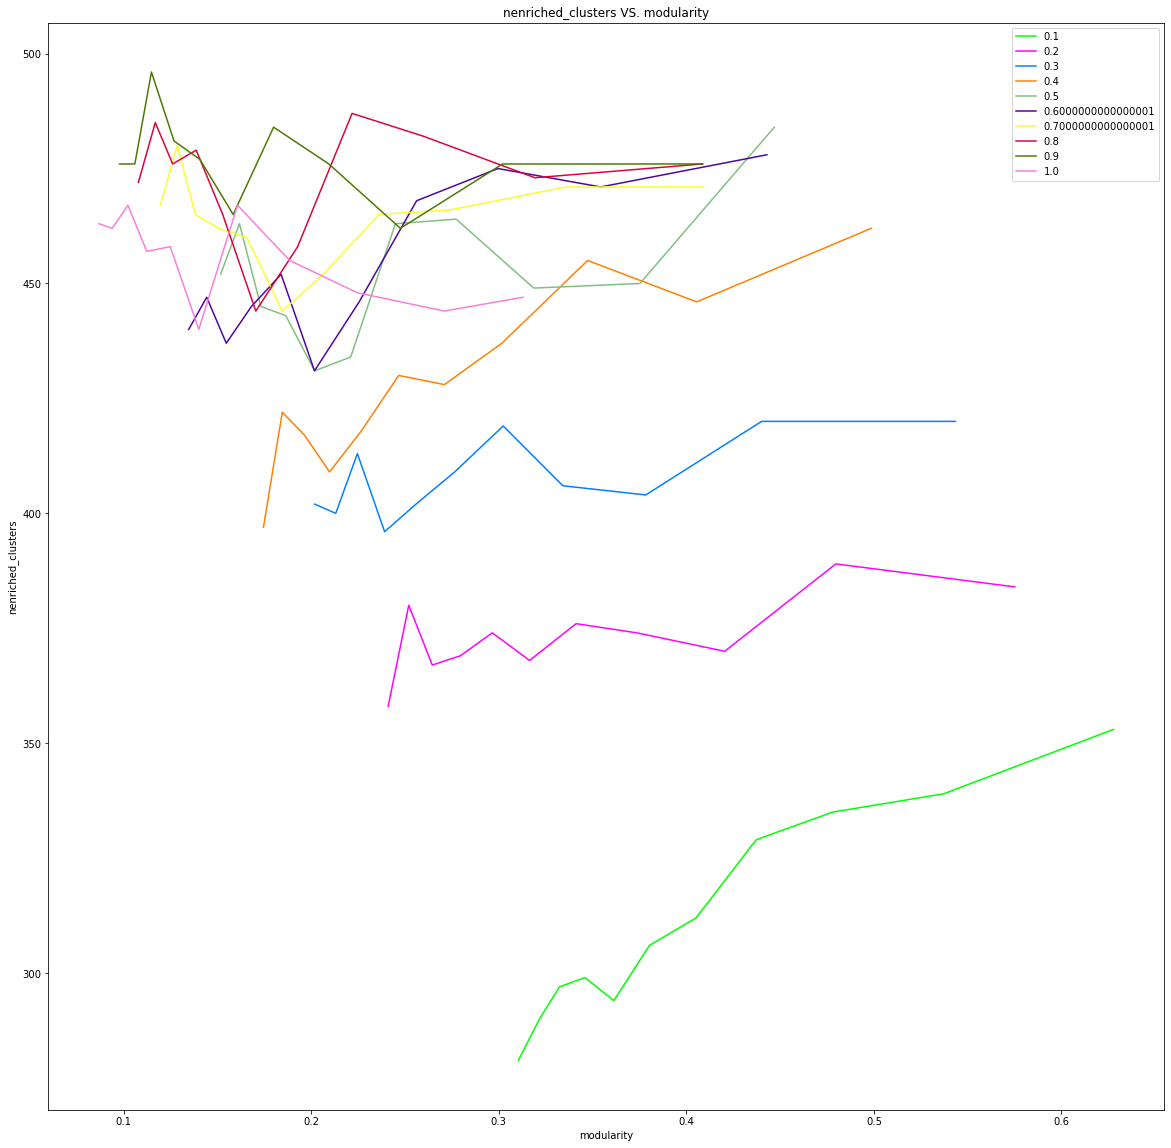

In [358]:
plt.figure(figsize=(20, 20))

for idx, p in enumerate(plot_ps):
    df = df_stats_true.loc[
        # (df_stats_true['nns'] == 6) & 
        (df_stats_true['parameter'] == p) & 

        (df_stats_true['dimensionality'] == 'baseline') &
        (df_stats_true['graph'] == 'umap_fuzzy_simplicial_set') &
        (df_stats_true['clustering'] == 'leiden_cpm') &
        (df_stats_true['metric'] == plotting_metric) &
        (df_stats_true['nclusters'] > 50)
    ]

    y = 'nenriched_clusters'
    # y = 'num_clusters_fraction_of_genes_enriched'

    # x = 'silhouette_score'
    x = 'modularity'

    plt.plot(df[x].values, df[y].values, label=str(p), color=colors[idx])

# Set axis labels and title
plt.xlabel(x)
plt.ylabel(y)
plt.title(f'{y} VS. {x}')

# Display the plot
plt.legend()
plt.show()

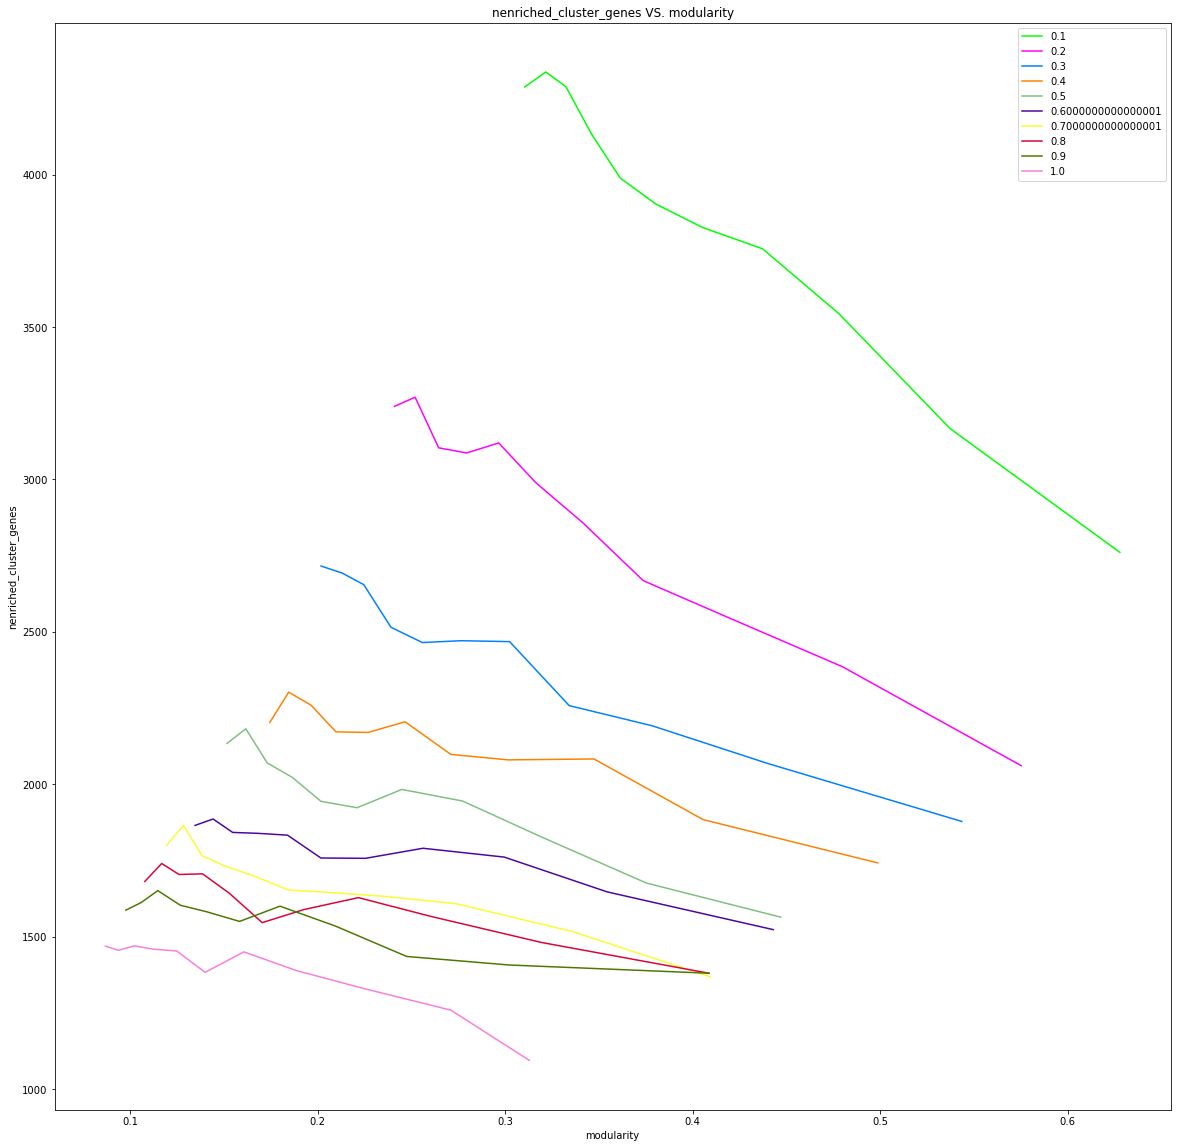

In [359]:
plt.figure(figsize=(20, 20))

for idx, p in enumerate(plot_ps):
    df = df_stats_true.loc[
        # (df_stats_true['nns'] == 6) & 
        (df_stats_true['parameter'] == p) & 

        (df_stats_true['dimensionality'] == 'baseline') &
        (df_stats_true['graph'] == 'umap_fuzzy_simplicial_set') &
        (df_stats_true['clustering'] == 'leiden_cpm') &
        (df_stats_true['metric'] == plotting_metric) &
        (df_stats_true['nclusters'] > 50)
    ]

    y = 'nenriched_cluster_genes'
    # y = 'num_clusters_fraction_of_genes_enriched'

    # x = 'silhouette_score'
    x = 'modularity'

    plt.plot(df[x].values, df[y].values, label=str(p), color=colors[idx])

# Set axis labels and title
plt.xlabel(x)
plt.ylabel(y)
plt.title(f'{y} VS. {x}')

# Display the plot
plt.legend()
plt.show()

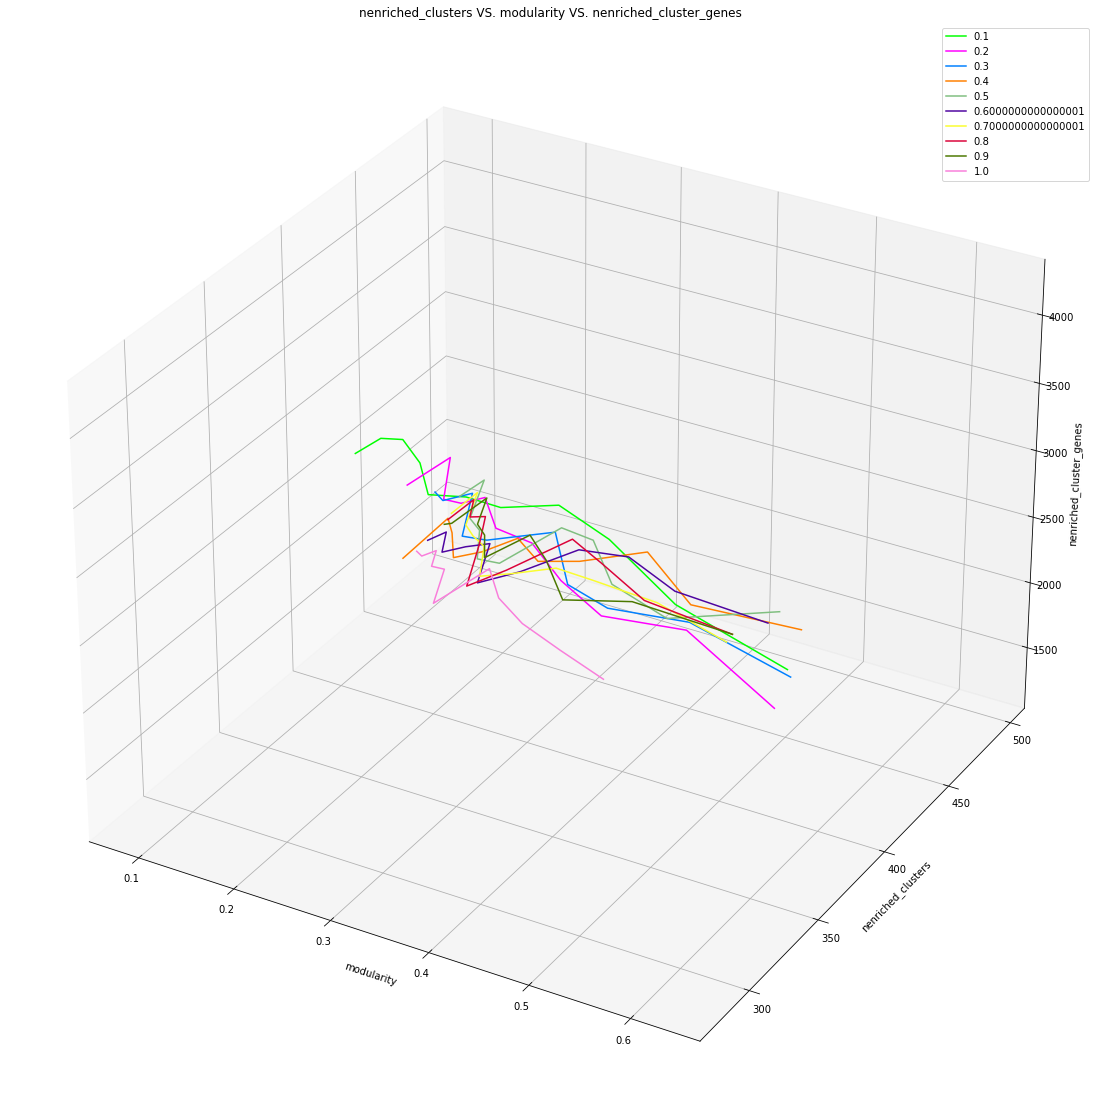

In [360]:
import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(111, projection='3d')

for idx, p in enumerate(plot_ps):
    df = df_stats_true.loc[
        # (df_stats_true['nns'] == 6) & 
        (df_stats_true['parameter'] == p) & 
        (df_stats_true['dimensionality'] == 'baseline') &
        (df_stats_true['graph'] == 'umap_fuzzy_simplicial_set') &
        (df_stats_true['clustering'] == 'leiden_cpm') &
        (df_stats_true['metric'] == plotting_metric) &
        (df_stats_true['nclusters'] > 50)
    ]

    y = 'nenriched_clusters'
    x = 'modularity'
    z = 'nenriched_cluster_genes'

    ax.plot(df[x].values, df[y].values, df[z].values, label=str(p), color=colors[idx])

# Set axis labels and title
ax.set_xlabel(x)
ax.set_ylabel(y)
ax.set_zlabel(z)
plt.title(f'{y} VS. {x} VS. {z}')

# Display the plot
plt.legend()
plt.show()

# NN SCATTER FOR VARYING RP PLOTTING PARAMETERS

0.1


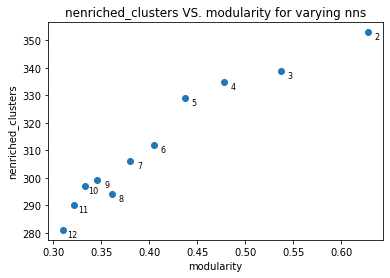

0.2


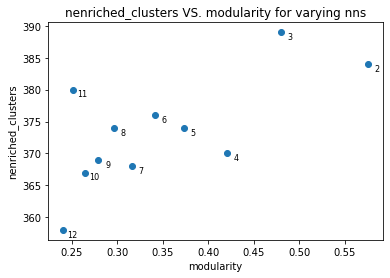

0.3


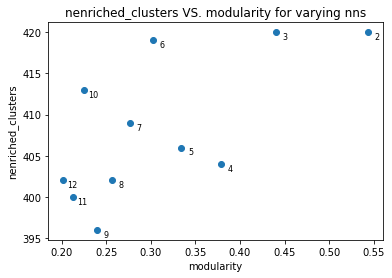

0.4


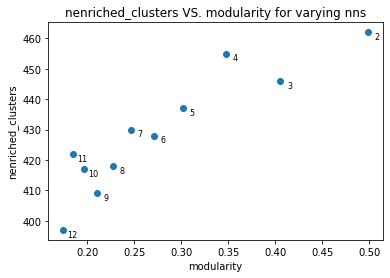

0.5


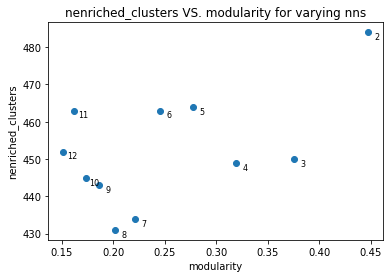

0.6000000000000001


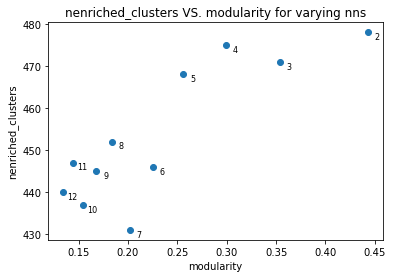

0.7000000000000001


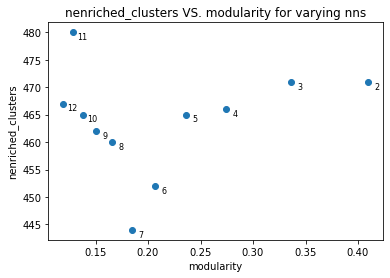

0.8


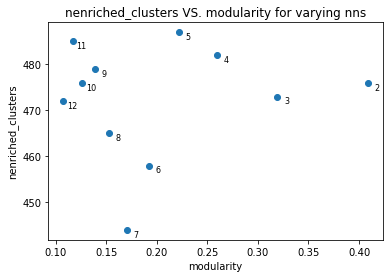

0.9


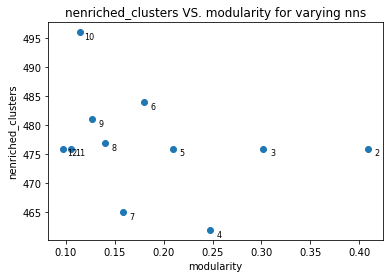

1.0


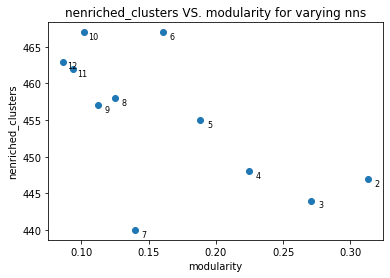

In [361]:
for p in sorted(df_stats_true['parameter'].unique()):
    df = df_stats_true.loc[
        # (df_stats_true['nns'] == 6) & 
        (df_stats_true['parameter'] == p) & 

        (df_stats_true['dimensionality'] == 'baseline') &
        (df_stats_true['graph'] == 'umap_fuzzy_simplicial_set') &
        (df_stats_true['clustering'] == 'leiden_cpm') &
        (df_stats_true['metric'] == plotting_metric) &
        (df_stats_true['nclusters'] > 50)
    ]

    y = 'nenriched_clusters'
    # y = 'num_clusters_fraction_of_genes_enriched'

    # x = 'silhouette_score'
    x = 'modularity'

    # labels = 'parameter'
    labels = 'nns'

    # Create scatter plot
    plt.scatter(df[x].values, df[y].values)

    label_adj = (df[x].max() - df[x].min()) * 0.03

    # Label each point with the number of nearest neighbors below the point
    for i, txt in enumerate(df[labels].values):
        plt.text(df[x].values[i] + label_adj, df[y].values[i], str(txt),
                fontsize=8, ha='center', va='top', color='black')

    # Set axis labels and title
    plt.xlabel(x)
    plt.ylabel(y)
    plt.title(f'{y} VS. {x} for varying {labels}')

    # Display the plot
    print(p)
    plt.show()